In [1]:
import ee
import folium
import colorcet as cc
import io
import os
import time
from PIL import Image
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

ee.Initialize()

# foliumマップにGEEを表示させる関数
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict["tile_fetcher"].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True,
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer


In [2]:
# ポリゴン座標（Research4_chiba_detail.ipynbと同じ）
coords = [
    [140.048947, 35.14381],
    [140.048947, 35.161424],
    [140.068946, 35.161424],
    [140.068946, 35.14381],
    [140.048947, 35.14381]
]
stat_region = ee.Geometry.Polygon(coords)

# 対象日付
target_dates = ["2025-04-21", "2025-11-07"]

# Sentinel-2のデータの収集
from datetime import datetime, timedelta

Sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

def maskS2clouds(image):
    qa = image.select("QA60")
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000).copyProperties(image, ["system:time_start"])

def calc_ndvi(image):
    return ee.Image(
        image.expression(
            "(NIR-RED)/(NIR+RED)",
            {"RED": image.select("B4"), "NIR": image.select("B8")},
        )
    ).rename("NDVI")

# 各日付の画像を取得（前後3日間の範囲で）
date_images = {}

for date in target_dates:
    date_obj = datetime.strptime(date, "%Y-%m-%d")
    start_date = (date_obj - timedelta(days=3)).strftime("%Y-%m-%d")
    end_date = (date_obj + timedelta(days=3)).strftime("%Y-%m-%d")
    
    date_collection_range = (
        Sentinel2
        .filterDate(f"{start_date}T00:00:00", f"{end_date}T23:59:59")
        .filterBounds(stat_region)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 30))
        .map(maskS2clouds)
        .sort("system:time_start")
    )
    
    count_range = date_collection_range.size().getInfo()
    if count_range > 0:
        target_time = ee.Date(f"{date}T12:00:00").millis()
        date_collection = date_collection_range.map(
            lambda img: img.set("time_diff", ee.Number(img.get("system:time_start")).subtract(target_time).abs())
        ).sort("time_diff").limit(1)
        date_image = date_collection.sort("system:time_start").first()
        date_images[date] = date_image
        date_images[f"{date}_ndvi"] = calc_ndvi(date_image)
        print(f"✓ {date}の画像を取得しました")
    else:
        print(f"⚠ {date}の画像が見つかりませんでした")

# NDVI差分を計算（2025-11-07 - 2025-04-21）
ndvi_first = date_images.get("2025-04-21_ndvi")
ndvi_last = date_images.get("2025-11-07_ndvi")

if ndvi_first and ndvi_last:
    ndvi_diff = ndvi_last.subtract(ndvi_first)
    print("✓ NDVI差分を計算しました")
else:
    print("⚠ NDVI差分の計算に失敗しました")


✓ 2025-04-21の画像を取得しました
✓ 2025-11-07の画像を取得しました
✓ NDVI差分を計算しました


In [3]:
# ポリゴン内のNDVI値を計算・出力

# 各日付のNDVI画像を取得
ndvi_first = date_images.get("2025-04-21_ndvi")
ndvi_last = date_images.get("2025-11-07_ndvi")

if ndvi_first and ndvi_last:
    # 各日付のNDVI値をポリゴン内で計算
    print("=== ポリゴン内のNDVI統計情報 ===\n")
    
    for date, ndvi_img in [("2025-04-21", ndvi_first), ("2025-11-07", ndvi_last)]:
        print(f"計算中: {date}...")
        # NDVI画像をクリップ
        ndvi_clipped = ndvi_img.select("NDVI").clip(stat_region)
        
        # 統計情報を取得（処理を分割してタイムアウトを回避）
        try:
            ndvi_stats = ndvi_clipped.reduceRegion(
                reducer=ee.Reducer.minMax().combine(
                    ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True), '', True
                ),
                geometry=stat_region,
                scale=10,
                maxPixels=1e9,
                bestEffort=True
            ).getInfo()
            
            print(f"日付: {date}")
            print(f"  最小値: {ndvi_stats.get('NDVI_min', 'N/A'):.4f}")
            print(f"  最大値: {ndvi_stats.get('NDVI_max', 'N/A'):.4f}")
            print(f"  平均値: {ndvi_stats.get('NDVI_mean', 'N/A'):.4f}")
            print(f"  標準偏差: {ndvi_stats.get('NDVI_stdDev', 'N/A'):.4f}")
            print()
        except Exception as e:
            print(f"⚠ {date}の統計情報取得に失敗: {str(e)}")
            print()
    
    # NDVI差分の統計情報も出力
    try:
        print("計算中: NDVI差分...")
        ndvi_diff_clipped = ndvi_diff.select("NDVI").clip(stat_region)
        diff_stats = ndvi_diff_clipped.reduceRegion(
            reducer=ee.Reducer.minMax().combine(
                ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True), '', True
            ),
            geometry=stat_region,
            scale=10,
            maxPixels=1e9,
            bestEffort=True
        ).getInfo()
        
        print("NDVI差分（2025-11-07 - 2025-04-21）:")
        print(f"  最小値: {diff_stats.get('NDVI_min', 'N/A'):.4f}")
        print(f"  最大値: {diff_stats.get('NDVI_max', 'N/A'):.4f}")
        print(f"  平均値: {diff_stats.get('NDVI_mean', 'N/A'):.4f}")
        print(f"  標準偏差: {diff_stats.get('NDVI_stdDev', 'N/A'):.4f}")
    except NameError:
        print("⚠ NDVI差分が定義されていません。Cell 1を先に実行してください。")
    except Exception as e:
        print(f"⚠ NDVI差分の統計情報取得に失敗: {str(e)}")
    
    print("\n=== 出力完了 ===")
else:
    print("⚠ NDVI画像が見つかりませんでした")


=== ポリゴン内のNDVI統計情報 ===

計算中: 2025-04-21...
日付: 2025-04-21
  最小値: 0.0163
  最大値: 0.8874
  平均値: 0.7984
  標準偏差: 0.0811

計算中: 2025-11-07...
日付: 2025-11-07
  最小値: 0.0531
  最大値: 0.9430
  平均値: 0.7888
  標準偏差: 0.1573

計算中: NDVI差分...
NDVI差分（2025-11-07 - 2025-04-21）:
  最小値: -0.7712
  最大値: 0.3869
  平均値: -0.0096
  標準偏差: 0.1552

=== 出力完了 ===


In [4]:
# NDVI差分を2値化（閾値以下=白（伐採）、閾値以上=黒（増加・変化なし））
# 閾値: より大きなNDVI減少のみを伐採領域として抽出
threshold = -0.2  # -0.2より小さい（大きな減少）を白（伐採）、それ以外を黒

# NDVI差分をクリップ
ndvi_diff_clipped = ndvi_diff.select("NDVI").clip(stat_region)

# NDVI差分の統計情報を取得（閾値設定の参考用）
ndvi_diff_stats = ndvi_diff_clipped.reduceRegion(
    reducer=ee.Reducer.minMax().combine(
        ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True), '', True
    ),
    geometry=stat_region,
    scale=10,
    maxPixels=1e9
).getInfo()

print("NDVI差分の統計情報:")
print(f"  最小値: {ndvi_diff_stats.get('NDVI_min', 'N/A'):.4f}")
print(f"  最大値: {ndvi_diff_stats.get('NDVI_max', 'N/A'):.4f}")
print(f"  平均値: {ndvi_diff_stats.get('NDVI_mean', 'N/A'):.4f}")
print(f"  標準偏差: {ndvi_diff_stats.get('NDVI_stdDev', 'N/A'):.4f}")

# 2値化画像を作成：閾値以下（大きな減少）= 255（白）、閾値以上（増加・変化なし）= 0（黒）
binary_image = ndvi_diff_clipped.expression(
    '(NDVI < threshold) ? 255 : 0',
    {'NDVI': ndvi_diff_clipped, 'threshold': threshold}
).unmask(0).uint8()  # マスクされた領域も0（黒）として表示

# 伐採領域の面積を計算
logging_mask = ndvi_diff_clipped.lt(threshold).selfMask()
pixel_count = logging_mask.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=stat_region,
    scale=10,  # Sentinel-2の解像度（10m）
    maxPixels=1e9
).getInfo()

pixel_size = 10  # メートル
pixel_count_value = pixel_count.get("NDVI", 0)
area_square_meters = pixel_count_value * (pixel_size ** 2)
area_hectares = area_square_meters / 10000  # ヘクタールに変換

print(f"\n✓ NDVI差分を2値化しました")
print(f"  閾値: {threshold}（NDVI差分が{threshold}より小さい領域を伐採として抽出）")
print("  白（255）= 伐採領域（NDVI大幅減少）、黒（0）= その他")
print(f"\n伐採領域の面積:")
print(f"  ピクセル数: {pixel_count_value:,.0f}")
print(f"  面積: {area_square_meters:,.2f} m²")
print(f"  面積: {area_hectares:.4f} ha")


NDVI差分の統計情報:
  最小値: -0.7712
  最大値: 0.3869
  平均値: -0.0096
  標準偏差: 0.1552

✓ NDVI差分を2値化しました
  閾値: -0.2（NDVI差分が-0.2より小さい領域を伐採として抽出）
  白（255）= 伐採領域（NDVI大幅減少）、黒（0）= その他

伐採領域の面積:
  ピクセル数: 3,739
  面積: 373,900.00 m²
  面積: 37.3900 ha


=== NDVI差分の統計情報（絶対値表記、0以下のみ表示） ===
  最小値: 0.7712 (元の値: -0.7712)
  最大値: 0.0000 (元の値: 0.3869)
  平均値: 0.0096 (元の値: -0.0096)
  標準偏差: 0.1552
  平均 − 2σ: 0.3201 (元の値: -0.3201)
  閾値: 0.200 (元の値: -0.200)
  伐採領域（NDVI < -0.2）の面積: 37.3900 ha
  ピクセル数: 3,739


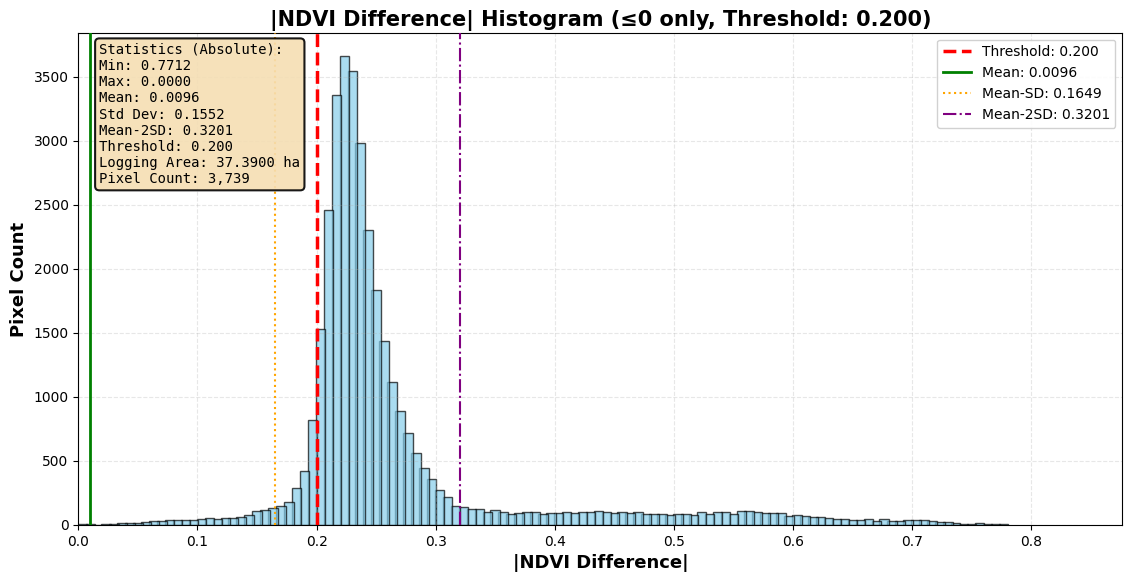

In [13]:
# NDVI差分のヒストグラムを表示（0以下のみ）
import matplotlib.pyplot as plt
import numpy as np

# 日本語フォントの設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# NDVI差分のヒストグラムデータを取得
histogram_diff = ndvi_diff_clipped.select("NDVI").reduceRegion(
    reducer=ee.Reducer.histogram(maxBuckets=256, minBucketWidth=0.01),
    geometry=stat_region,
    scale=10,
    maxPixels=1e9
).getInfo()

# ヒストグラムデータを抽出
hist_data_diff = histogram_diff.get('NDVI', {})
bucket_min_diff = hist_data_diff.get('bucketMin', 0)
bucket_max_diff = hist_data_diff.get('bucketMax', 0)
bucket_width_diff = hist_data_diff.get('bucketWidth', 0)
hist_counts_diff = hist_data_diff.get('histogram', [])

# バケットの中心値を計算
num_buckets_diff = len(hist_counts_diff)
buckets_diff = np.linspace(bucket_min_diff, bucket_max_diff, num_buckets_diff + 1)
buckets_center_diff = (buckets_diff[:-1] + buckets_diff[1:]) / 2

# 長さを確認して調整
if len(buckets_center_diff) != len(hist_counts_diff):
    min_len = min(len(buckets_center_diff), len(hist_counts_diff))
    buckets_center_diff = buckets_center_diff[:min_len]
    hist_counts_diff = hist_counts_diff[:min_len]

# 0以下の値のみをフィルタリング
mask_negative = buckets_center_diff <= 0
buckets_center_diff_filtered = buckets_center_diff[mask_negative]
hist_counts_diff_filtered = np.array(hist_counts_diff)[mask_negative]

# 絶対値に変換（表示用）
buckets_center_abs = np.abs(buckets_center_diff_filtered)

# 統計値を取得（NDVI差分）
ndvi_min = ndvi_diff_stats.get('NDVI_min', 0)
ndvi_max = ndvi_diff_stats.get('NDVI_max', 0)
ndvi_mean = ndvi_diff_stats.get('NDVI_mean', 0)
ndvi_std = ndvi_diff_stats.get('NDVI_stdDev', 0)

# 絶対値での統計値
ndvi_min_abs = abs(ndvi_min)
ndvi_max_abs = abs(ndvi_max) if ndvi_max < 0 else 0
ndvi_mean_abs = abs(ndvi_mean)
ndvi_std_abs = ndvi_std
threshold_abs = abs(threshold)
mean_minus_2sigma_abs = abs(ndvi_mean - 2 * ndvi_std)
mean_minus_sigma_abs = abs(ndvi_mean - ndvi_std)

# ヒストグラムをプロット（絶対値で表示）
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(buckets_center_abs, hist_counts_diff_filtered, 
              width=bucket_width_diff * 0.8, alpha=0.7, color='skyblue', edgecolor='black')
ax.axvline(x=threshold_abs, color='red', linestyle='--', linewidth=2.5, 
           label=f'Threshold: {threshold_abs:.3f}', zorder=5)
ax.axvline(x=ndvi_mean_abs, color='green', linestyle='-', linewidth=2, 
           label=f'Mean: {ndvi_mean_abs:.4f}', zorder=5)
ax.axvline(x=mean_minus_sigma_abs, color='orange', linestyle=':', linewidth=1.5, 
           label=f'Mean-SD: {mean_minus_sigma_abs:.4f}', zorder=5)
ax.axvline(x=mean_minus_2sigma_abs, color='purple', linestyle='-.', linewidth=1.5, 
           label=f'Mean-2SD: {mean_minus_2sigma_abs:.4f}', zorder=5)
ax.set_xlabel('|NDVI Difference|', fontsize=13, fontweight='bold')
ax.set_ylabel('Pixel Count', fontsize=13, fontweight='bold')
ax.set_title(f'|NDVI Difference| Histogram (≤0 only, Threshold: {threshold_abs:.3f})', 
             fontsize=15, fontweight='bold', pad=5)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.set_xlim(0, buckets_center_abs.max() + 0.1)

# ヒストグラムの最大値を取得して、統計情報の位置を調整
max_count = np.max(hist_counts_diff_filtered) if len(hist_counts_diff_filtered) > 0 else 0
y_max = ax.get_ylim()[1]

# 統計情報をテキストボックスで表示（絶対値表記）
stats_text = f"""Statistics (Absolute):
Min: {ndvi_min_abs:.4f}
Max: {ndvi_max_abs:.4f}
Mean: {ndvi_mean_abs:.4f}
Std Dev: {ndvi_std_abs:.4f}
Mean-2SD: {mean_minus_2sigma_abs:.4f}
Threshold: {threshold_abs:.3f}
Logging Area: {area_hectares:.4f} ha
Pixel Count: {pixel_count_value:,.0f}"""

# 統計情報を左側の空いている領域（データポイントが少ない領域）に配置
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        fontsize=10, verticalalignment='top', horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=1.5),
        family='monospace', zorder=10)

# 余白を最小化
plt.subplots_adjust(left=0.08, right=0.95, top=0.92, bottom=0.1)

# 統計情報をコンソールにも表示（絶対値表記）
print("=== NDVI差分の統計情報（絶対値表記、0以下のみ表示） ===")
print(f"  最小値: {ndvi_min_abs:.4f} (元の値: {ndvi_min:.4f})")
print(f"  最大値: {ndvi_max_abs:.4f} (元の値: {ndvi_max:.4f})")
print(f"  平均値: {ndvi_mean_abs:.4f} (元の値: {ndvi_mean:.4f})")
print(f"  標準偏差: {ndvi_std_abs:.4f}")
print(f"  平均 − 2σ: {mean_minus_2sigma_abs:.4f} (元の値: {ndvi_mean - 2 * ndvi_std:.4f})")
print(f"  閾値: {threshold_abs:.3f} (元の値: {threshold:.3f})")
print(f"  伐採領域（NDVI < {threshold}）の面積: {area_hectares:.4f} ha")
print(f"  ピクセル数: {pixel_count_value:,.0f}")

plt.show()


In [25]:
# 2025-11-07のNDVI画像をポリゴン内で表示（カラーバー付き）

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 2025-11-07のNDVI画像を取得
ndvi_last = date_images.get("2025-11-07_ndvi")
if ndvi_last:
    # NDVI画像をポリゴン内でクリップ
    ndvi_last_clipped = ndvi_last.select("NDVI").clip(stat_region)
    
    # NDVI画像の統計情報を取得（カラーバーの範囲設定用）
    ndvi_stats = ndvi_last_clipped.reduceRegion(
        reducer=ee.Reducer.minMax().combine(
            ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True), '', True
        ),
        geometry=stat_region,
        scale=10,
        maxPixels=1e9,
        bestEffort=True
    ).getInfo()
    
    ndvi_min = ndvi_stats.get('NDVI_min', 0)
    ndvi_max = ndvi_stats.get('NDVI_max', 1)
    ndvi_mean = ndvi_stats.get('NDVI_mean', 0.5)
    ndvi_std = ndvi_stats.get('NDVI_stdDev', 0.1)
    
    print(f"NDVI統計情報（2025-11-07）:")
    print(f"  最小値: {ndvi_min:.4f}")
    print(f"  最大値: {ndvi_max:.4f}")
    print(f"  平均値: {ndvi_mean:.4f}")
    print(f"  標準偏差: {ndvi_std:.4f}")
    
    # Foliumマップを作成（ベースマップを非表示にしてNDVI画像のみを表示）
    center_lat = (35.14381 + 35.161424) / 2
    center_lon = (140.048947 + 140.068946) / 2
    
    # ポリゴンの範囲を最小限に設定（拡大しない）
    lat_min = min(coord[1] for coord in coords[:-1])
    lat_max = max(coord[1] for coord in coords[:-1])
    lon_min = min(coord[0] for coord in coords[:-1])
    lon_max = max(coord[0] for coord in coords[:-1])
    
    # ポリゴンの範囲のみを使用（拡大しない）
    bounds = [
        [lat_min, lon_min],
        [lat_max, lon_max]
    ]
    
    # ベースマップを表示（地図背景）
    ndvi_map = folium.Map(location=[center_lat, center_lon], zoom_start=14)
    visualization_ndvi = {
        "min": 0.0,
        "max": 1.0,
        "palette": ["white", "red", "yellow", "lightgreen", "green", "blue"]
    }
    
    # NDVI画像を追加（ポリゴン内でクリップ済み）
    ndvi_map.add_ee_layer(ndvi_last_clipped, visualization_ndvi, "NDVI")
    folium.Map.add_ee_layer = add_ee_layer
    
    # ポリゴンの境界線を追加
    polygon_coords_folium = [[coord[1], coord[0]] for coord in coords[:-1]]
    folium.Polygon(
        locations=polygon_coords_folium,
        color='blue',
        weight=3,
        fillColor='blue',
        fillOpacity=0.1,
        popup='Research Area (Polygon)',
        tooltip='Research Area'
    ).add_to(ndvi_map)
    
    # マップの範囲を設定（ポリゴンの範囲のみ、パディングなし）
    ndvi_map.fit_bounds(bounds, padding=(0, 0))
    
    # マップを一時HTMLファイルに保存
    temp_html_ndvi = "temp_ndvi_last.html"
    ndvi_map.save(temp_html_ndvi)
    print("✓ マップを一時保存しました")
    
    # Seleniumでスクリーンショットを取得
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--window-size=1920,1080')
    
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(f"file://{os.path.abspath(temp_html_ndvi)}")
    
    # マップの読み込みを待機
    wait = WebDriverWait(driver, 30)
    map_element = wait.until(EC.presence_of_element_located((By.CLASS_NAME, "folium-map")))
    
    # 画像読み込み待機（NDVI画像のタイルが読み込まれるまで待機）
    time.sleep(25)
    
    # fit_boundsが正しく適用されるようにJavaScriptで再設定（パディングなし）
    driver.execute_script("""
        var mapDiv = document.querySelector('.folium-map');
        if (mapDiv && mapDiv._leaflet_id) {
            var map = window[mapDiv._leaflet_id];
            if (map) {
                var bounds = [[%f, %f], [%f, %f]];
                map.fitBounds(bounds, {padding: [0, 0]});
                map.invalidateSize();
                // NDVIレイヤーが表示されるまで待機
                setTimeout(function() {
                    map.invalidateSize();
                    // レイヤーを再読み込み
                    map.eachLayer(function(layer) {
                        if (layer.options && layer.options.name === 'NDVI') {
                            layer.redraw();
                        }
                    });
                    // 再度fitBoundsを実行して範囲を確実に設定
                    map.fitBounds(bounds, {padding: [0, 0]});
                }, 3000);
            }
        }
    """ % (bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]))
    time.sleep(8)
    
    # マップ要素のスクリーンショットを取得
    screenshot = map_element.screenshot_as_png
    driver.quit()
    
    # 画像を読み込み
    ndvi_img = Image.open(io.BytesIO(screenshot))
    img_width, img_height = ndvi_img.size
    
    # ポリゴンの範囲を画像座標に変換してクロップ
    # マップの境界を取得（JavaScriptで取得したboundsを使用）
    # 画像内でのポリゴンの位置を計算
    # マップの表示範囲と画像サイズから、ポリゴンの位置を推定
    
    # マップの表示範囲（bounds）から、画像内でのポリゴンの位置を計算
    # マップの中心とズームレベルから、画像内での座標を計算
    # 簡易的な方法：画像の中央部分をクロップ（ポリゴンが中央にあると仮定）
    # より正確には、マップのboundsと画像サイズから計算する必要がある
    
    # ポリゴンの範囲を画像座標に変換してクロップ
    # 左右のみをカット（上下はカットしない）
    crop_margin_horizontal = 0.15  # 左右15%をカット
    left = int(img_width * crop_margin_horizontal)
    top = 0  # 上はカットしない
    right = int(img_width * (1 - crop_margin_horizontal))
    bottom = img_height  # 下はカットしない
    
    # 画像をクロップ（左右のみ）
    ndvi_img_cropped = ndvi_img.crop((left, top, right, bottom))
    print(f"✓ 画像をクロップしました: {img_width}x{img_height} → {ndvi_img_cropped.width}x{ndvi_img_cropped.height}")
    print(f"  左右マージン: {crop_margin_horizontal*100:.0f}% (左右のみをカット)")
    
    img_array = np.array(ndvi_img_cropped)
    
    # 図を作成（画像と同じサイズ）
    fig, ax = plt.subplots(figsize=(img_array.shape[1]/100, img_array.shape[0]/100), dpi=100)
    ax.imshow(img_array)
    ax.axis('off')
    
    # NDVIのカラーパレット
    colors_ndvi = ['white', 'red', 'yellow', 'lightgreen', 'green', 'blue']
    n_bins = 256
    cmap_ndvi = mcolors.LinearSegmentedColormap.from_list('ndvi', colors_ndvi, N=n_bins)
    
    # カラーバーを追加
    norm_ndvi = mcolors.Normalize(vmin=0.0, vmax=1.0)
    sm_ndvi = plt.cm.ScalarMappable(cmap=cmap_ndvi, norm=norm_ndvi)
    sm_ndvi.set_array([])
    
    # 画像の右側にカラーバーを配置
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    cbar = plt.colorbar(sm_ndvi, cax=cax, orientation='vertical')
    cbar.set_label('NDVI', fontsize=14, fontweight='bold', rotation=270, labelpad=20)
    cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    cbar.set_ticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
    cbar.ax.tick_params(labelsize=12)
    
    # タイトルを追加（英語表記で文字抜けを回避）
    ax.text(0.5, 0.98, 'NDVI Image (2025-11-07)',
            transform=ax.transAxes,
            ha='center', va='top',
            fontsize=16, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', linewidth=2),
            family='DejaVu Sans')
    
    # PNGとして保存
    plt.tight_layout(pad=0)
    output_path = "NDVI_last_20251107_with_colorbar.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight', pad_inches=0, facecolor='white')
    plt.close()
    
    # 一時ファイルを削除
    if os.path.exists(temp_html_ndvi):
        os.remove(temp_html_ndvi)
    
    print(f"\n✓ NDVI画像（カラーバー付き）を '{output_path}' に保存しました")
    print(f"  日付: 2025-11-07")
    print(f"  範囲: ポリゴン内（最小限）")
    print(f"  NDVI範囲: 0.0 - 1.0")
    
else:
    print("⚠ 2025-11-07のNDVI画像が見つかりませんでした")


NDVI統計情報（2025-11-07）:
  最小値: 0.0531
  最大値: 0.9430
  平均値: 0.7888
  標準偏差: 0.1573
✓ マップを一時保存しました
✓ 画像をクロップしました: 1920x941 → 1344x941
  左右マージン: 15% (左右のみをカット)

✓ NDVI画像（カラーバー付き）を 'NDVI_last_20251107_with_colorbar.png' に保存しました
  日付: 2025-11-07
  範囲: ポリゴン内（最小限）
  NDVI範囲: 0.0 - 1.0


In [ ]:
# 2025-11-07のNDVI画像をポリゴン内で表示（1/4正方形と中心点付き、カラーバー付き）

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 2025-11-07のNDVI画像を取得
ndvi_last = date_images.get("2025-11-07_ndvi")
if ndvi_last:
    # NDVI画像をポリゴン内でクリップ
    ndvi_last_clipped = ndvi_last.select("NDVI").clip(stat_region)
    
    # ポリゴンの中心点と1/4正方形を計算
    center_lat = (35.14381 + 35.161424) / 2
    center_lon = (140.048947 + 140.068946) / 2
    
    # ポリゴンのサイズを計算
    lon_range = 140.068946 - 140.048947
    lat_range = 35.161424 - 35.14381
    
    # 1/4サイズの正方形を作成（小さい方の範囲を使用）
    quarter_size = min(lon_range, lat_range) / 4
    quarter_square_coords = [
        [center_lon - quarter_size, center_lat - quarter_size],
        [center_lon - quarter_size, center_lat + quarter_size],
        [center_lon + quarter_size, center_lat + quarter_size],
        [center_lon + quarter_size, center_lat - quarter_size],
        [center_lon - quarter_size, center_lat - quarter_size]
    ]
    
    # Foliumマップを作成（地図背景）
    ndvi_map = folium.Map(location=[center_lat, center_lon], zoom_start=14)
    visualization_ndvi = {
        "min": 0.0,
        "max": 1.0,
        "palette": ["white", "red", "yellow", "lightgreen", "green", "blue"]
    }
    
    # NDVI画像を追加
    ndvi_map.add_ee_layer(ndvi_last_clipped, visualization_ndvi, "NDVI")
    folium.Map.add_ee_layer = add_ee_layer
    
    # ポリゴンの境界線を追加
    polygon_coords_folium = [[coord[1], coord[0]] for coord in coords[:-1]]
    folium.Polygon(
        locations=polygon_coords_folium,
        color='blue',
        weight=3,
        fillColor='blue',
        fillOpacity=0.1,
        popup='Research Area (Polygon)',
        tooltip='Research Area'
    ).add_to(ndvi_map)
    
    # 1/4サイズの正方形を追加（白線）
    quarter_coords_folium = [[coord[1], coord[0]] for coord in quarter_square_coords[:-1]]
    folium.Polygon(
        locations=quarter_coords_folium,
        color='white',
        weight=3,
        fillColor='white',
        fillOpacity=0.0,  # 塗りつぶしなし
        popup='1/4 Size Square',
        tooltip='1/4 Square'
    ).add_to(ndvi_map)
    
    # 中心点を追加（青色）
    folium.Marker(
        location=[center_lat, center_lon],
        popup=f'Center Point<br>Lat: {center_lat:.6f}<br>Lon: {center_lon:.6f}',
        tooltip='Center Point',
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(ndvi_map)
    
    # マップの範囲を設定
    bounds = [
        [min(coord[1] for coord in coords[:-1]), min(coord[0] for coord in coords[:-1])],
        [max(coord[1] for coord in coords[:-1]), max(coord[0] for coord in coords[:-1])]
    ]
    ndvi_map.fit_bounds(bounds, padding=(0, 0))
    
    # マップを一時HTMLファイルに保存
    temp_html_ndvi = "temp_ndvi_last_with_quarter.html"
    ndvi_map.save(temp_html_ndvi)
    print("✓ マップを一時保存しました")
    
    # Seleniumでスクリーンショットを取得
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--window-size=1920,1080')
    
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(f"file://{os.path.abspath(temp_html_ndvi)}")
    
    # マップの読み込みを待機
    wait = WebDriverWait(driver, 30)
    map_element = wait.until(EC.presence_of_element_located((By.CLASS_NAME, "folium-map")))
    
    # 画像読み込み待機
    time.sleep(25)
    
    # fit_boundsが正しく適用されるようにJavaScriptで再設定
    driver.execute_script("""
        var mapDiv = document.querySelector('.folium-map');
        if (mapDiv && mapDiv._leaflet_id) {
            var map = window[mapDiv._leaflet_id];
            if (map) {
                var bounds = [[%f, %f], [%f, %f]];
                map.fitBounds(bounds, {padding: [0, 0]});
                map.invalidateSize();
                setTimeout(function() {
                    map.invalidateSize();
                    map.eachLayer(function(layer) {
                        if (layer.options && layer.options.name === 'NDVI') {
                            layer.redraw();
                        }
                    });
                    map.fitBounds(bounds, {padding: [0, 0]});
                }, 3000);
            }
        }
    """ % (bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]))
    time.sleep(8)
    
    # マップ要素のスクリーンショットを取得
    screenshot = map_element.screenshot_as_png
    driver.quit()
    
    # 画像を読み込み
    ndvi_img = Image.open(io.BytesIO(screenshot))
    img_width, img_height = ndvi_img.size
    
    # 左右のみをカット
    crop_margin_horizontal = 0.15
    left = int(img_width * crop_margin_horizontal)
    top = 0
    right = int(img_width * (1 - crop_margin_horizontal))
    bottom = img_height
    
    # 画像をクロップ（左右のみ）
    ndvi_img_cropped = ndvi_img.crop((left, top, right, bottom))
    print(f"✓ 画像をクロップしました: {img_width}x{img_height} → {ndvi_img_cropped.width}x{ndvi_img_cropped.height}")
    
    img_array = np.array(ndvi_img_cropped)
    
    # 図を作成
    fig, ax = plt.subplots(figsize=(img_array.shape[1]/100, img_array.shape[0]/100), dpi=100)
    ax.imshow(img_array)
    ax.axis('off')
    
    # NDVIのカラーパレット
    colors_ndvi = ['white', 'red', 'yellow', 'lightgreen', 'green', 'blue']
    n_bins = 256
    cmap_ndvi = mcolors.LinearSegmentedColormap.from_list('ndvi', colors_ndvi, N=n_bins)
    
    # カラーバーを追加
    norm_ndvi = mcolors.Normalize(vmin=0.0, vmax=1.0)
    sm_ndvi = plt.cm.ScalarMappable(cmap=cmap_ndvi, norm=norm_ndvi)
    sm_ndvi.set_array([])
    
    # 画像の右側にカラーバーを配置
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    cbar = plt.colorbar(sm_ndvi, cax=cax, orientation='vertical')
    cbar.set_label('NDVI', fontsize=14, fontweight='bold', rotation=270, labelpad=20)
    cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    cbar.set_ticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
    cbar.ax.tick_params(labelsize=12)
    
    # タイトルを追加
    ax.text(0.5, 0.98, 'NDVI Image (2025-11-07) with 1/4 Square & Center',
            transform=ax.transAxes,
            ha='center', va='top',
            fontsize=16, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', linewidth=2),
            family='DejaVu Sans')
    
    # PNGとして保存
    plt.tight_layout(pad=0)
    output_path = "NDVI_last_20251107_with_quarter_center_colorbar.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight', pad_inches=0, facecolor='white')
    plt.close()
    
    # 一時ファイルを削除
    if os.path.exists(temp_html_ndvi):
        os.remove(temp_html_ndvi)
    
    print(f"\n✓ NDVI画像（1/4正方形・中心点・カラーバー付き）を '{output_path}' に保存しました")
    print(f"  日付: 2025-11-07")
    print(f"  範囲: ポリゴン内")
    print(f"  1/4正方形: 緑色のポリゴン")
    print(f"  中心点: 赤色のマーカー")
    print(f"  NDVI範囲: 0.0 - 1.0")
    
else:
    print("⚠ 2025-11-07のNDVI画像が見つかりませんでした")


✓ マップを一時保存しました
✓ 画像をクロップしました: 1920x941 → 1344x941

✓ NDVI画像（1/4正方形・中心点・カラーバー付き）を 'NDVI_last_20251107_with_quarter_center_colorbar.png' に保存しました
  日付: 2025-11-07
  範囲: ポリゴン内
  1/4正方形: 緑色のポリゴン
  中心点: 赤色のマーカー
  NDVI範囲: 0.0 - 1.0


In [13]:
# 2値化画像をFoliumマップで表示

# マップの中心点を計算
center_lat = (35.14381 + 35.161424) / 2
center_lon = (140.048947 + 140.068946) / 2

# 2値化画像の可視化パラメータ（白=減少、黒=増加・変化なし）
visualization_binary = {
    "min": 0,
    "max": 255,
    "palette": ["black", "white"]  # 0=黒（増加・変化なし）、255=白（減少）
}

# Foliumマップを作成
area_map = folium.Map(location=[center_lat, center_lon], zoom_start=14)

# 2値化画像を追加
area_map.add_ee_layer(binary_image, visualization_binary, "NDVI差分（2値化：白=減少、黒=増加・変化なし）")

# ポリゴンの境界線を追加
polygon_coords_folium = [[coord[1], coord[0]] for coord in coords[:-1]]
folium.Polygon(
    locations=polygon_coords_folium,
    color='blue',
    weight=3,
    fillColor='blue',
    fillOpacity=0.1,
    popup='研究範囲（ポリゴン）',
    tooltip='研究範囲'
).add_to(area_map)

# マップの範囲を設定
bounds = [[min(coord[1] for coord in coords[:-1]), min(coord[0] for coord in coords[:-1])],
          [max(coord[1] for coord in coords[:-1]), max(coord[0] for coord in coords[:-1])]]
area_map.fit_bounds(bounds, padding=(10, 10))

# マップを一時HTMLファイルに保存
temp_html = "temp_ndvi_diff_binary.html"
area_map.save(temp_html)
print("✓ マップを一時保存しました")

# マップを表示
area_map


✓ マップを一時保存しました


In [15]:
# RGB、NDVI、2値化画像を並べてPNGとして保存

# 1. RGB画像（2025-11-07）のマップを作成
rgb_map = folium.Map(location=[center_lat, center_lon], zoom_start=14)
visualization_RGB = {"min": 0.0, "max": 0.3, "bands": ["B4", "B3", "B2"]}
rgb_image = date_images.get("2025-11-07")
if rgb_image:
    rgb_map.add_ee_layer(rgb_image, visualization_RGB, "RGB")
    polygon_coords_folium = [[coord[1], coord[0]] for coord in coords[:-1]]
    folium.Polygon(
        locations=polygon_coords_folium,
        color='blue',
        weight=3,
        fillColor='blue',
        fillOpacity=0.1,
        popup='研究範囲',
        tooltip='研究範囲'
    ).add_to(rgb_map)
    rgb_map.fit_bounds(bounds, padding=(10, 10))
    rgb_map.add_child(folium.LayerControl(collapsed=False))
    folium.Map.add_ee_layer = add_ee_layer

# 2. NDVI画像（2025-11-07）のマップを作成
ndvi_map = folium.Map(location=[center_lat, center_lon], zoom_start=14)
visualization_ndvi = {
    "min": 0.0,
    "max": 1.0,
    "palette": ["white", "red", "yellow", "lightgreen", "green", "blue"]
}
ndvi_last_clipped = ndvi_last.select("NDVI").clip(stat_region)
ndvi_map.add_ee_layer(ndvi_last_clipped, visualization_ndvi, "NDVI")
folium.Polygon(
    locations=polygon_coords_folium,
    color='blue',
    weight=3,
    fillColor='blue',
    fillOpacity=0.1,
    popup='研究範囲',
    tooltip='研究範囲'
).add_to(ndvi_map)
ndvi_map.fit_bounds(bounds, padding=(10, 10))
ndvi_map.add_child(folium.LayerControl(collapsed=False))
folium.Map.add_ee_layer = add_ee_layer

# 3. 2値化画像のマップ（既存のarea_mapを使用）

# 各マップを一時HTMLファイルに保存
rgb_html = "temp_rgb_map.html"
ndvi_html = "temp_ndvi_map.html"
binary_html = "temp_binary_map.html"

rgb_map.save(rgb_html)
ndvi_map.save(ndvi_html)
area_map.save(binary_html)

# Seleniumで各マップのスクリーンショットを取得
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--window-size=2000,2000')

driver = webdriver.Chrome(options=chrome_options)

def capture_map_screenshot(html_path, map_name):
    driver.get(f'file://{os.path.abspath(html_path)}')
    wait = WebDriverWait(driver, 30)
    map_element = wait.until(EC.presence_of_element_located((By.CLASS_NAME, "folium-map")))
    time.sleep(15)
    driver.execute_script("""
        var mapDiv = document.querySelector('.folium-map');
        if (mapDiv && mapDiv._leaflet_id) {
            var map = window[mapDiv._leaflet_id];
            if (map) {
                var bounds = [[%f, %f], [%f, %f]];
                map.fitBounds(bounds);
                map.invalidateSize();
            }
        }
    """ % (bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]))
    time.sleep(5)
    screenshot = map_element.screenshot_as_png
    print(f"✓ {map_name}のスクリーンショットを取得しました")
    return Image.open(io.BytesIO(screenshot))

# 各マップのスクリーンショットを取得
rgb_img = capture_map_screenshot(rgb_html, "RGB")
ndvi_img = capture_map_screenshot(ndvi_html, "NDVI")
binary_img = capture_map_screenshot(binary_html, "2値化")

driver.quit()

# 3つの画像を横に並べて結合
# 各画像のサイズを統一
width = rgb_img.width
height = rgb_img.height

# 画像をリサイズ（必要に応じて）
ndvi_img = ndvi_img.resize((width, height), Image.Resampling.LANCZOS)
binary_img = binary_img.resize((width, height), Image.Resampling.LANCZOS)

# 横に並べた画像を作成
combined_width = width * 3
combined_height = height
combined_img = Image.new('RGB', (combined_width, combined_height))

# 画像を配置
combined_img.paste(rgb_img, (0, 0))
combined_img.paste(ndvi_img, (width, 0))
combined_img.paste(binary_img, (width * 2, 0))

# PNGとして保存
output_path = "NDVI_comparison_RGB_NDVI_Binary.png"
combined_img.save(output_path, "PNG", optimize=True, quality=95)

# 一時ファイルを削除
for temp_file in [rgb_html, ndvi_html, binary_html, temp_html]:
    if os.path.exists(temp_file):
        os.remove(temp_file)

print(f"\n✓ 結合PNG画像を '{output_path}' に保存しました")
print(f"  左: RGB画像（2025-11-07）")
print(f"  中央: NDVI画像（2025-11-07）")
print(f"  右: NDVI差分2値化画像（白=伐採、黒=その他）")
print(f"\n結果サマリー:")
print(f"  閾値: {threshold}")
print(f"  伐採面積: {area_hectares:.4f} ha ({area_square_meters:,.2f} m²)")
print(f"  NDVI差分統計:")
print(f"    最小値: {ndvi_diff_stats.get('NDVI_min', 'N/A'):.4f}")
print(f"    最大値: {ndvi_diff_stats.get('NDVI_max', 'N/A'):.4f}")
print(f"    平均値: {ndvi_diff_stats.get('NDVI_mean', 'N/A'):.4f}")
print(f"    標準偏差: {ndvi_diff_stats.get('NDVI_stdDev', 'N/A'):.4f}")


✓ RGBのスクリーンショットを取得しました
✓ NDVIのスクリーンショットを取得しました
✓ 2値化のスクリーンショットを取得しました

✓ 結合PNG画像を 'NDVI_comparison_RGB_NDVI_Binary.png' に保存しました
  左: RGB画像（2025-11-07）
  中央: NDVI画像（2025-11-07）
  右: NDVI差分2値化画像（白=伐採、黒=その他）

結果サマリー:
  閾値: -0.2
  伐採面積: 37.3900 ha (373,900.00 m²)
  NDVI差分統計:
    最小値: -0.7712
    最大値: 0.3869
    平均値: -0.0096
    標準偏差: 0.1552


In [25]:
# RGB画像上に伐採箇所を赤色でオーバーレイ表示

# 伐採箇所のマスク（NDVI差分が閾値より小さい領域）
logging_mask = ndvi_diff_clipped.lt(threshold)

# RGB画像を取得（2025-11-07）
rgb_image = date_images.get("2025-11-07")
if rgb_image:
    # RGB画像はクリップせず、全体を表示（ポリゴン外も含む）
    # RGB画像のバンドを取得
    rgb_bands = rgb_image.select(['B4', 'B3', 'B2'])
    
    # 伐採箇所を赤色でオーバーレイ
    # 伐採マスクをポリゴン外も含めて拡張（ポリゴン外は伐採マスクを0にする）
    logging_mask_extended = logging_mask.clip(stat_region).unmask(0)
    
    # RGB画像の値は0-1の範囲なので、赤色も同じ範囲で設定
    # 伐採箇所では赤色（1.0, 0.0, 0.0）を使用、それ以外は元のRGB値を使用
    red_band = rgb_bands.select('B4').where(logging_mask_extended, 1.0)  # 伐採箇所=1.0（赤）、その他=元の値
    green_band = rgb_bands.select('B3').where(logging_mask_extended, 0.0)  # 伐採箇所=0.0、その他=元の値
    blue_band = rgb_bands.select('B2').where(logging_mask_extended, 0.0)   # 伐採箇所=0.0、その他=元の値
    
    # 3つのバンドを結合
    rgb_with_logging = ee.Image.cat([red_band, green_band, blue_band]).rename(['B4', 'B3', 'B2'])
    
    # マップを作成
    logging_overlay_map = folium.Map(location=[center_lat, center_lon], zoom_start=14)
    
    # RGB画像（伐採箇所を赤色で表示）を追加
    visualization_RGB_logging = {"min": 0.0, "max": 0.3, "bands": ["B4", "B3", "B2"]}
    logging_overlay_map.add_ee_layer(rgb_with_logging, visualization_RGB_logging, "RGB（赤=伐採箇所）")
    
    # ポリゴンの境界線を追加
    polygon_coords_folium = [[coord[1], coord[0]] for coord in coords[:-1]]
    folium.Polygon(
        locations=polygon_coords_folium,
        color='blue',
        weight=3,
        fillColor='blue',
        fillOpacity=0.1,
        popup='研究範囲（ポリゴン）',
        tooltip='研究範囲'
    ).add_to(logging_overlay_map)
    
    # マップの範囲を設定
    logging_overlay_map.fit_bounds(bounds, padding=(10, 10))
    logging_overlay_map.add_child(folium.LayerControl(collapsed=False))
    folium.Map.add_ee_layer = add_ee_layer
    
    # マップを一時HTMLファイルに保存
    logging_html = "temp_rgb_logging_overlay.html"
    logging_overlay_map.save(logging_html)
    
    # マップを表示
    logging_overlay_map
    
    print("✓ RGB画像上に伐採箇所を赤色でオーバーレイ表示しました")
    print(f"  伐採面積: {area_hectares:.4f} ha")
    
    # PNGとして保存
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--window-size=2000,2000')
    
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(f'file://{os.path.abspath(logging_html)}')
    
    wait = WebDriverWait(driver, 30)
    map_element = wait.until(EC.presence_of_element_located((By.CLASS_NAME, "folium-map")))
    time.sleep(15)
    
    driver.execute_script("""
        var mapDiv = document.querySelector('.folium-map');
        if (mapDiv && mapDiv._leaflet_id) {
            var map = window[mapDiv._leaflet_id];
            if (map) {
                var bounds = [[%f, %f], [%f, %f]];
                map.fitBounds(bounds);
                map.invalidateSize();
            }
        }
    """ % (bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]))
    time.sleep(5)
    
    screenshot = map_element.screenshot_as_png
    driver.quit()
    
    # PNGとして保存
    output_path = "RGB_logging_overlay.png"
    Image.open(io.BytesIO(screenshot)).save(output_path, "PNG", optimize=True, quality=95)
    
    # 一時ファイルを削除
    if os.path.exists(logging_html):
        os.remove(logging_html)
    
    print(f"✓ PNG画像を '{output_path}' に保存しました")
else:
    print("⚠ RGB画像が見つかりませんでした")


✓ RGB画像上に伐採箇所を赤色でオーバーレイ表示しました
  伐採面積: 37.3900 ha
✓ PNG画像を 'RGB_logging_overlay.png' に保存しました
